# Assignment 1.2 - Linear classifier

In this assignment we implement linear classifier. Linear classifier computes the score of a class as a weighted sum of all its features. The class that has the biggest sum is the model prediction.


In this assignment we
- train to calculate gradients of multivariable functions.
- implement evaluation of the gradients through the linear model and loss fuction softmax 
- implement training of linear classifier
- choosing training parameters 

Numpy tutorial:  
http://cs231n.github.io/python-numpy-tutorial/

In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Load the data

Using SVHN.

In [10]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    # add 1 as the last column
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val: train_X 9000, val_X - 1000
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Let's play with gradients!

All functions to claculate gradients will follow the same algorithm.  

The input is the point where the function and its gradient need to be calculated. The output is the tuple of two values- function and analitical expression for the gradint (same dimension as the input) .
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

We'll start with calculating the numeric gradient `check_gradient` in `gradient_check.py`. This function takes input parameters outlined above, use `value`to calculate numeric gradient и compares it with the analytic one - they should match.

Write the code that calculates numeric gradient for each coordinate. For analytic gradient calculation use so called two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

All functions in the next cell must undergo gradient check.

In [11]:
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## We'll start writing functions, calculating analytic gradient

We'll implement softmax function, that has input parameters estimates for each class and convert them to probabilities:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Important:** In practice softmax deals with the exponents of potentially big numbers. This could lead to huge numbers in the nominator and denominator and, hence, loss of precision.

Luckily this problem has a simple solution -- before calculating of softmax subtract max value of all estimates from all estimates:
```
predictions -= np.max(predictions)
```
(see - http://cs231n.github.io/linear-classify/#softmax, sectin `Practical issues: Numeric stability`)

In [12]:
# Implementing softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Besides, we claculate cross-entropy loss, which we use as an error function.
In general case cross-entropy is defined as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

where x - all classes p(x) -true probability of belonging of sample to class x, and  принадлежности сэмпла классу x, а q(x) - probability of belonging of sample to class x predicted by the model .  
In our case the sample belongs only to one class, for it p(x) equals 1, and for all other classes  - p(x) equals 0. 
This assumption simplifies the task!

In [13]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
#linear_classifer.cross_entropy_loss(probs, np.array([1]))
linear_classifer.cross_entropy_loss(probs, 0)
#linear_classifer.cross_entropy_loss(probs, 2)

10.00676044354712

Now we can calculate gradient.

It happens that gradient calculation become simpler if we cmbine all these functions in one, that first calculate probabilities through softmax and then use them to calculate loss function through cross-entropy loss.

This function `softmax_with_cross_entropy` will return loss function and gradient function. We'll use `check_gradient` to confirm the correctness of our calculations.

In [14]:
# Implementing of combined function or softmax and cross entropy and produces gradient
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

We'll use stochastic gradient descent or SGD that use sample batch. 

All our functions will receive a batch or matrix of dimensions `batch_size, num_classes`. The index of sample will be the first.

Next step -to re-write the functions so that they support the batches.

The final value of loss function must be a mean value over all samples in the batch.

In [15]:
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
#predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
predictions = np.array([ 1.,  2., -1.,  1.])
print("predictions",predictions)
#target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
target_index =np.array([2])
print("target_index",target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions [ 1.  2. -1.  1.]
target_index [2]
Gradient check passed!


True

In [16]:
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print("predictions",predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print("target_index",target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)


predictions [[ 1.  2. -1.  1.]
 [ 1.  2. -1. -1.]
 [ 1.  0.  1.  1.]]
target_index [[2]
 [2]
 [3]]
Gradient check passed!


True

In [17]:
# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
print(probs)
assert np.all(np.isclose(probs[:, 0], 1.0))

[[9.99999996e-01 2.06115361e-09 2.06115361e-09]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]]


### Finally, linear classifier!

Softmax и cross-entropy receves input parameters that are estimates of linear classifier .

It does it very simple: each class is a weighted sum of pixels of the pictures. The resulting nuber is an estimate for the class that is an input parameter for softmax.

Thus, linear classifier is a product of pixel vector and matrix W with the shape of `num_features, num_classes`. This approach is easily extended to the case of batch of vectors of size of X `batch_size, num_features`:

`predictions = X * W`, where `*` - product of matrices.

Implement`linear_softmax` in `linear_classifer.py`

In [18]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index1 = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)

print("X",X)
print("W",W)
print("target_index",target_index1)
loss, dW = linear_classifer.linear_softmax(X, W, target_index1)
print("loss",loss,"dW",dW)
print("target_index",target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index1), W)

X [[-1. -1.  1.]
 [ 0.  1.  1.]]
W [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
target_index [[0]
 [0]]
loss 3.1755153626167147 dW [[ 0.11920292 -0.11920292]
 [-0.8333712   0.8333712 ]
 [-1.07177705  1.07177705]]
target_index [[2]
 [2]
 [3]]
Gradient check passed!


True

### Regularisation

We'll use L2 regularization for the weights as part of the general loss function.

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>


In [19]:
# Implementing of l2_regularization function
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Training!

In [20]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

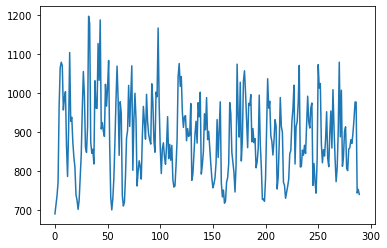

In [21]:
# let's look at the loss history!
plt.plot(loss_history)

In [22]:
y=np.array([[0.11244485, 0.12054929, 0.31551177, 0.1267941 , 0.25395222],
       [0.11335934, 0.18233905, 0.1999285 , 0.12207216, 0.20330039],
       [0.11637693, 0.13970159, 0.26050083, 0.42353186, 0.27269168],
       [0.15453344, 0.13717516, 0.14920566, 0.18677121, 0.21439832]])
b = np.max(y, axis=1)
print(b)
c=np.argmax(y, axis=1)
c

[0.31551177 0.20330039 0.42353186 0.21439832]


array([2, 4, 3, 4])

In [23]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.177
Accuracy after training for 100 epochs:  0.19


### We'll use cross-validation to choose the hyper-parameter.

This time to save time we'll use one split for training and validation data.

We need to choose two hyper parameters! Do not limit yourself with the initial choice.  
Try to get accuracy more than **20%** on validation data.

In [24]:
import itertools
num_epochs = 200
batch_size = 300

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
reg_strengths = [1, 0.1, 1e-2,1e-3,1e-4, 1e-5, 1e-6, 1e-7]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
ac_to_params = {}
indexes = list(itertools.product(learning_rates, reg_strengths))
for l_rate, reg_st in indexes:
    classifier.fit(train_X, train_y, batch_size=300, learning_rate=l_rate, reg=reg_st, epochs=100, )
    
    pred = classifier.predict(val_X)
    accuracy = multiclass_accuracy(pred, val_y)
    ac_to_params[accuracy] = (classifier,l_rate,reg_st)
    
for l in sorted(ac_to_params, reverse = True):
    print(l,ac_to_params[l])


0.252 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 1e-05, 0.01)
0.251 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 1e-05, 0.0001)
0.25 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 1e-06, 1e-06)
0.249 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 1e-06, 1e-07)
0.248 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 1e-05, 1e-06)
0.247 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 1e-07)
0.246 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 0.0001)
0.245 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 0.001)
0.243 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 0.1)
0.242 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 0.01)
0.241 (<linear_classifer.LinearSoftmaxClassifier object at 0x11603d130>, 0.0001, 1)
0.214 (<linear_classifer.LinearSoftmaxClassi

In [25]:
(best_val_accuracy,(best_classifier,best_learning_rate, best_reg_strength))=sorted(ac_to_params.items(), key = 
             lambda kv: kv[0], reverse = True)[0]
best_val_accuracy = best_val_accuracy*100
print('best validation accuracy achieved: %d' % best_val_accuracy)
print(best_classifier)
print(best_learning_rate)
print(best_reg_strength)


best validation accuracy achieved: 25
1e-05
0.01


# What is the accuracy for the test data?

In [26]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
test_accuracy = test_accuracy *100
print('Linear softmax classifier test set accuracy: %d' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 20
